# digital narratives of COVID-19: frequency bar chart

In this notebook we demonstrate how to use *coveet*, a Python script that retrieves basic statistics (most frequent words, bigrams, trigrams, top users, hashtags) from our curated COVID-19 database about our collection. We visualize the results using bar charts to get a sense of top words/bigrams/trigrams/ec. over the span of a week in each geographic area. Please feel free to modify this notebook or, if you would like to preserve this version, make a copy of it by clicking "File" > "Make a Copy..."

To follow along, we recommend running the script portions piecemeal, in order.

__Author:__

* Jerry Bonnell, [j.bonnell@miami.edu](mailto:j.bonnell@miami.edu), University of Miami


## Table of Contents

0. Setting Up 
1. Querying the database API
2. Tidying up the queried data 
3. Retrieving top n-grams or hashtags
4. Visualization
5. More advanced explorations
    - 5.1. Concordance views
    - 5.2. Unique words by location-language pair mode
    - 5.3. Unique words by date mode


## 0. Setting Up

Before we get started, let's set up the notebook by installing and importing libraries we need. The `requirements.txt` file specifies all the packages to install on your computer for this notebook. 

In [ ]:
!pip3 install -r requirements.txt  # may need to replace "pip3" with "conda"

In [1]:
import numpy as np
import pandas as pd
from coveet import count_ngrams, uniq_vocab_by_group
from collections import Counter
from pprint import pprint
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

## 1. Querying the database API

__NOTE__ Documentation for the coveet tool is available on the [project GitHub](https://github.com/dh-miami/narratives_covid19/tree/master/scripts/freq_analysis).

We first use coveet to query one week of tweets written in each geographic area. All of the geolocated tweets are written in Spanish, with the exception of Florida where both Spanish and English tweets are obtained. 

In [5]:
!python3 coveet.py query -g fl ar co ec es mx pe -l en es -d 2020-05-08 2020-05-14

Namespace(date=[datetime.datetime(2020, 5, 8, 0, 0), datetime.datetime(2020, 5, 14, 0, 0)], func=<function handle_query at 0x12f09bf80>, geo=['fl', 'ar', 'co', 'ec', 'es', 'mx', 'pe'], lang=['en', 'es'])
wrote df to dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv 🎉


The coveet script just wrote the results to a CSV file called `dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv`. Let's load in this CSV using `pandas`.

In [2]:
df = pd.read_csv('dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv', index_col=0)

Let's have a look at what this dataframe looks like...

In [3]:
df

,date,lang,geo,text,hashtags
0,2020-05-08,es,es,este es jose gonzalez medico residente de neumologia ha encontrado una cura para el covid19 se que no lo compartiras porque no es futbolista,NaN
1,2020-05-08,es,es,ingreso en un hospital veterinario con dificultades para respirar 382 grados de temperatura nivel bajo de plaquetas y una insuficiencia cardiaca pero claro mejor decir que murio de covid19 sois unos mierdas,NaN
2,2020-05-08,es,es,una pregunta a los vallisoletanos estais de acuerdo con que el y excluyan al concejal de del grupo de trabajo para mejorar la situacion creada por la crisis del covid19solo por pedir que se debata en el proximo pleno :male_sign:,NaN
3,2020-05-08,es,es,muere el torturador franquista billy el niño por covid19 sin haber sido juzgado por sus crimenes,NaN
4,2020-05-08,es,es,tengo una conocida sanitaria que dio positivo en covid19 con anticuerpos en sangre se contagio trabajando y se negaron a hacerle el pcr a su familia,#mileniolive
...,...,...,...,...,...
224732,2020-05-14,en,fl,breaking dr fauci proclaims 8 new covid19 vaccines will be ready in the fall,NaN
224733,2020-05-14,en,fl,in an sec filing dating back to last week uber disclosed plans to layoff 3700 employees the figure amounts to around 14 percent of the ride hailing giantrsquos total workforce in the document the company states that the,NaN
224734,2020-05-14,en,fl,join ms focus for a teleconference designed to help you improve your life with ms with expert speaker mitzi williams md and a topic you care about minorities and covid19 to join the teleconference call 7207409380 preregister today,NaN
224735,2020-05-14,en,fl,emotional roi should be one of your key performance indicators during covid19 video,NaN


Observe the stopwords present in the tweet text. Let's filter these out, as well as address some other preprocessing concerns in preparation for the visualization task...

## 2. Tidying up the queried data 

We will use the *tidy* mode from coveet to tidy up (or preprocess) the data frame we just obtained. At this moment, two preprocessing concerns take center stage: (1) eliminating __stopwords__, and (2) __lemmatization__ in order to group together all inflections of a word into a single item. Let's do each in turn.

First, we show how to eliminate stopwords from the query CSV file. The CSV file `dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv` is provided as input, and a filtered CSV file will be returned. We assume that the user has prepared a list of stopwords in English and Spanish. In this example, a file for stopwords in English and another in Spanish.

In [4]:
!python3 coveet.py tidy -file dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv -stopwords ../stopwords/stopwords_en.txt ../stopwords/stopwords_es.txt ../stopwords/stopwords_hashtags.txt

Namespace(file='dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv', func=<function handle_tidy at 0x127eda0e0>, lemmatize=False, stopwords=['../stopwords/stopwords_en.txt', '../stopwords/stopwords_es.txt', '../stopwords/stopwords_hashtags.txt'])
wrote tidied df to dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe_stopworded.csv 🎉


Stopword elimination and lemmatization can be done at the same time. However, because lemmatization can take __a long time for large query CSVs__, we did not pass a flag for it in the above command. This is how the above command would be amended to include lemmatization.

In [ ]:
!python3 coveet.py tidy -file dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv -lemmatize -stopwords ../stopwords/stopwords_en.txt ../stopwords/stopwords_es.txt ../stopwords/stopwords_hashtags.txt

Let's load in the tidied CSV with `pandas` again. 

In [6]:
df = pd.read_csv('dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe_stopworded.csv', index_col=0)

In [7]:
df

,date,lang,geo,text,hashtags
0,2020-05-08,es,es,jose gonzalez medico residente neumologia encontrado cura compartiras futbolista,NaN
1,2020-05-08,es,es,ingreso hospital veterinario dificultades respirar 382 grados temperatura nivel bajo plaquetas insuficiencia cardiaca claro mejor decir murio mierdas,NaN
2,2020-05-08,es,es,pregunta vallisoletanos estais acuerdo excluyan concejal grupo trabajo mejorar situacion creada crisis covid19solo pedir debata proximo pleno :male_sign:,NaN
3,2020-05-08,es,es,muere torturador franquista billy niño haber sido juzgado crimenes,NaN
4,2020-05-08,es,es,conocida sanitaria dio positivo anticuerpos sangre contagio trabajando negaron hacerle pcr familia,#mileniolive
...,...,...,...,...,...
224732,2020-05-14,en,fl,breaking dr fauci proclaims 8 new vaccines ready fall,NaN
224733,2020-05-14,en,fl,sec filing dating back last week uber disclosed plans layoff 3700 employees figure amounts around 14 percent ride hailing giantrsquos total workforce document company states,NaN
224734,2020-05-14,en,fl,join ms focus teleconference designed help improve life ms expert speaker mitzi williams md topic care minorities join teleconference call 7207409380 preregister today,NaN
224735,2020-05-14,en,fl,emotional roi one key performance indicators video,NaN


Much better :-) Before moving on, let's convert the date column to a `datetime` object since that makes working with dates easier. We will also turn the text and hashtags into lists which will ease processing later on. 

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['text'] = df['text'].str.split()
df['hashtags'] = df['hashtags'].str.split()

## 3. Retrieving top n-grams or hashtags

Let's have a look at the top 10 results in each area. First, we define some variables.

In [9]:
top_n = 10  # top 10 words
n_gram = 1  # ask for word frequency (i.e. an n-gram where n=1)

Let's toggle a variable to determine whether we will retrieve n-grams or hashtags.

In [10]:
col_name = 'text'  # set to either 'text' or 'hashtags'

We'll subset the dataframe to contain only tweets or hashtags based on this toggle variable, and drop any cells with missing values (due to a tweet consisting of a body but with no hashtags, or vice versa).  

In [11]:
df = df.dropna(subset=[col_name])

We will create another dictionary where each key is a location-language pair, and the value is a list of the top occurrences under that setting. The code here invokes a function `count_ngrams()` from coveet to prepare the top n-gram and hashtag information. 

A brief note on how these n-grams are obtained: I treat the full tweet as context, rather than adjacent neighbors, in light of how short a "tweet" unit is. For instance, when obtaining bigrams, I consider the occurrence of two words together in a tweet as bigrams, regardless of whether they are adjacent. This could lead to possibly interesting findings, but we should discuss. 

In [12]:
# counts is of the form: location, language, actual tuples
# count_ngrams returns a (default) dictionary of word tuples (ngrams) 
# with its associated frequency; we then use Counter from python collections 
# to tell us the top n most popular ones 
counts = {(g, l): Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n)
          for (g, l), t in df.groupby(["geo", "lang"])[col_name]}

Let's have a look at what we just did.

In [13]:
pprint(counts)

{('ar', 'es'): [(('casos',), 1789),
                (('mas',), 1490),
                (('pandemia',), 920),
                (('si',), 860),
                (('coronavirus',), 823),
                (('nuevos',), 766),
                (('hoy',), 727),
                (('salud',), 629),
                (('argentina',), 622),
                (('pais',), 582)],
 ('co', 'es'): [(('casos',), 4577),
                (('mas',), 4569),
                (('salud',), 2648),
                (('pandemia',), 2370),
                (('colombia',), 2189),
                (('si',), 2122),
                (('hoy',), 2001),
                (('nuevos',), 1889),
                (('mayo',), 1867),
                (('coronavirus',), 1866)],
 ('ec', 'es'): [(('mas',), 1357),
                (('casos',), 1019),
                (('salud',), 923),
                (('ecuador',), 726),
                (('pandemia',), 722),
                (('si',), 653),
                (('contagio',), 603),
                (('mayo',

## 4. Visualization

Now we're ready to visualize! First we initialize some `matplotlib`  settings.

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40  # setting figure size
plt.rcParams.update({'font.size': 22})  # setting font size

We create a matrix of bar charts, one for each location-language pair. The order visualization can be reversed by toggling the `invert_yaxis()` function call in `plot_bar_matrix()`.

In [15]:
def plot_bar_matrix(counts, num_cols):
    """
    function for plotting a matrix of bar plots 
    
    counts: a dictionary mapping from a geo-lang pair identifier (generalizable to any identifier)
            to a list of (word, count) tuples containing the top word frequencies
    num_cols: desired number of columns to show in the grid
    str_func: function for "pretty printing" the title used in each of the bar charts  
    """
    # automatically determine the grid to use based on desired number of columns 
    num_rows = len(counts.keys()) // num_cols
    num_rows += 1 if num_rows * num_cols < len(counts.keys()) else 0
    fig, axes = plt.subplots(num_rows, num_cols)
    flattened = axes.flatten()
    for i, (id_pair, counts) in enumerate(counts.items()):
        labels = [" ".join(w) for w, _ in counts]
        y = [n for _, n in counts]
        cmap = plt.get_cmap('spring')
        colors = plt.get_cmap('spring')(np.linspace(0, 1, len(labels)))
        flattened[i].set_title(f"{' '.join([str(p) for p in id_pair])}")
        flattened[i].barh(y=range(0,10), width=y, color=colors, tick_label=labels)
        flattened[i].invert_yaxis()  # reverse the visualization order along the y-axis

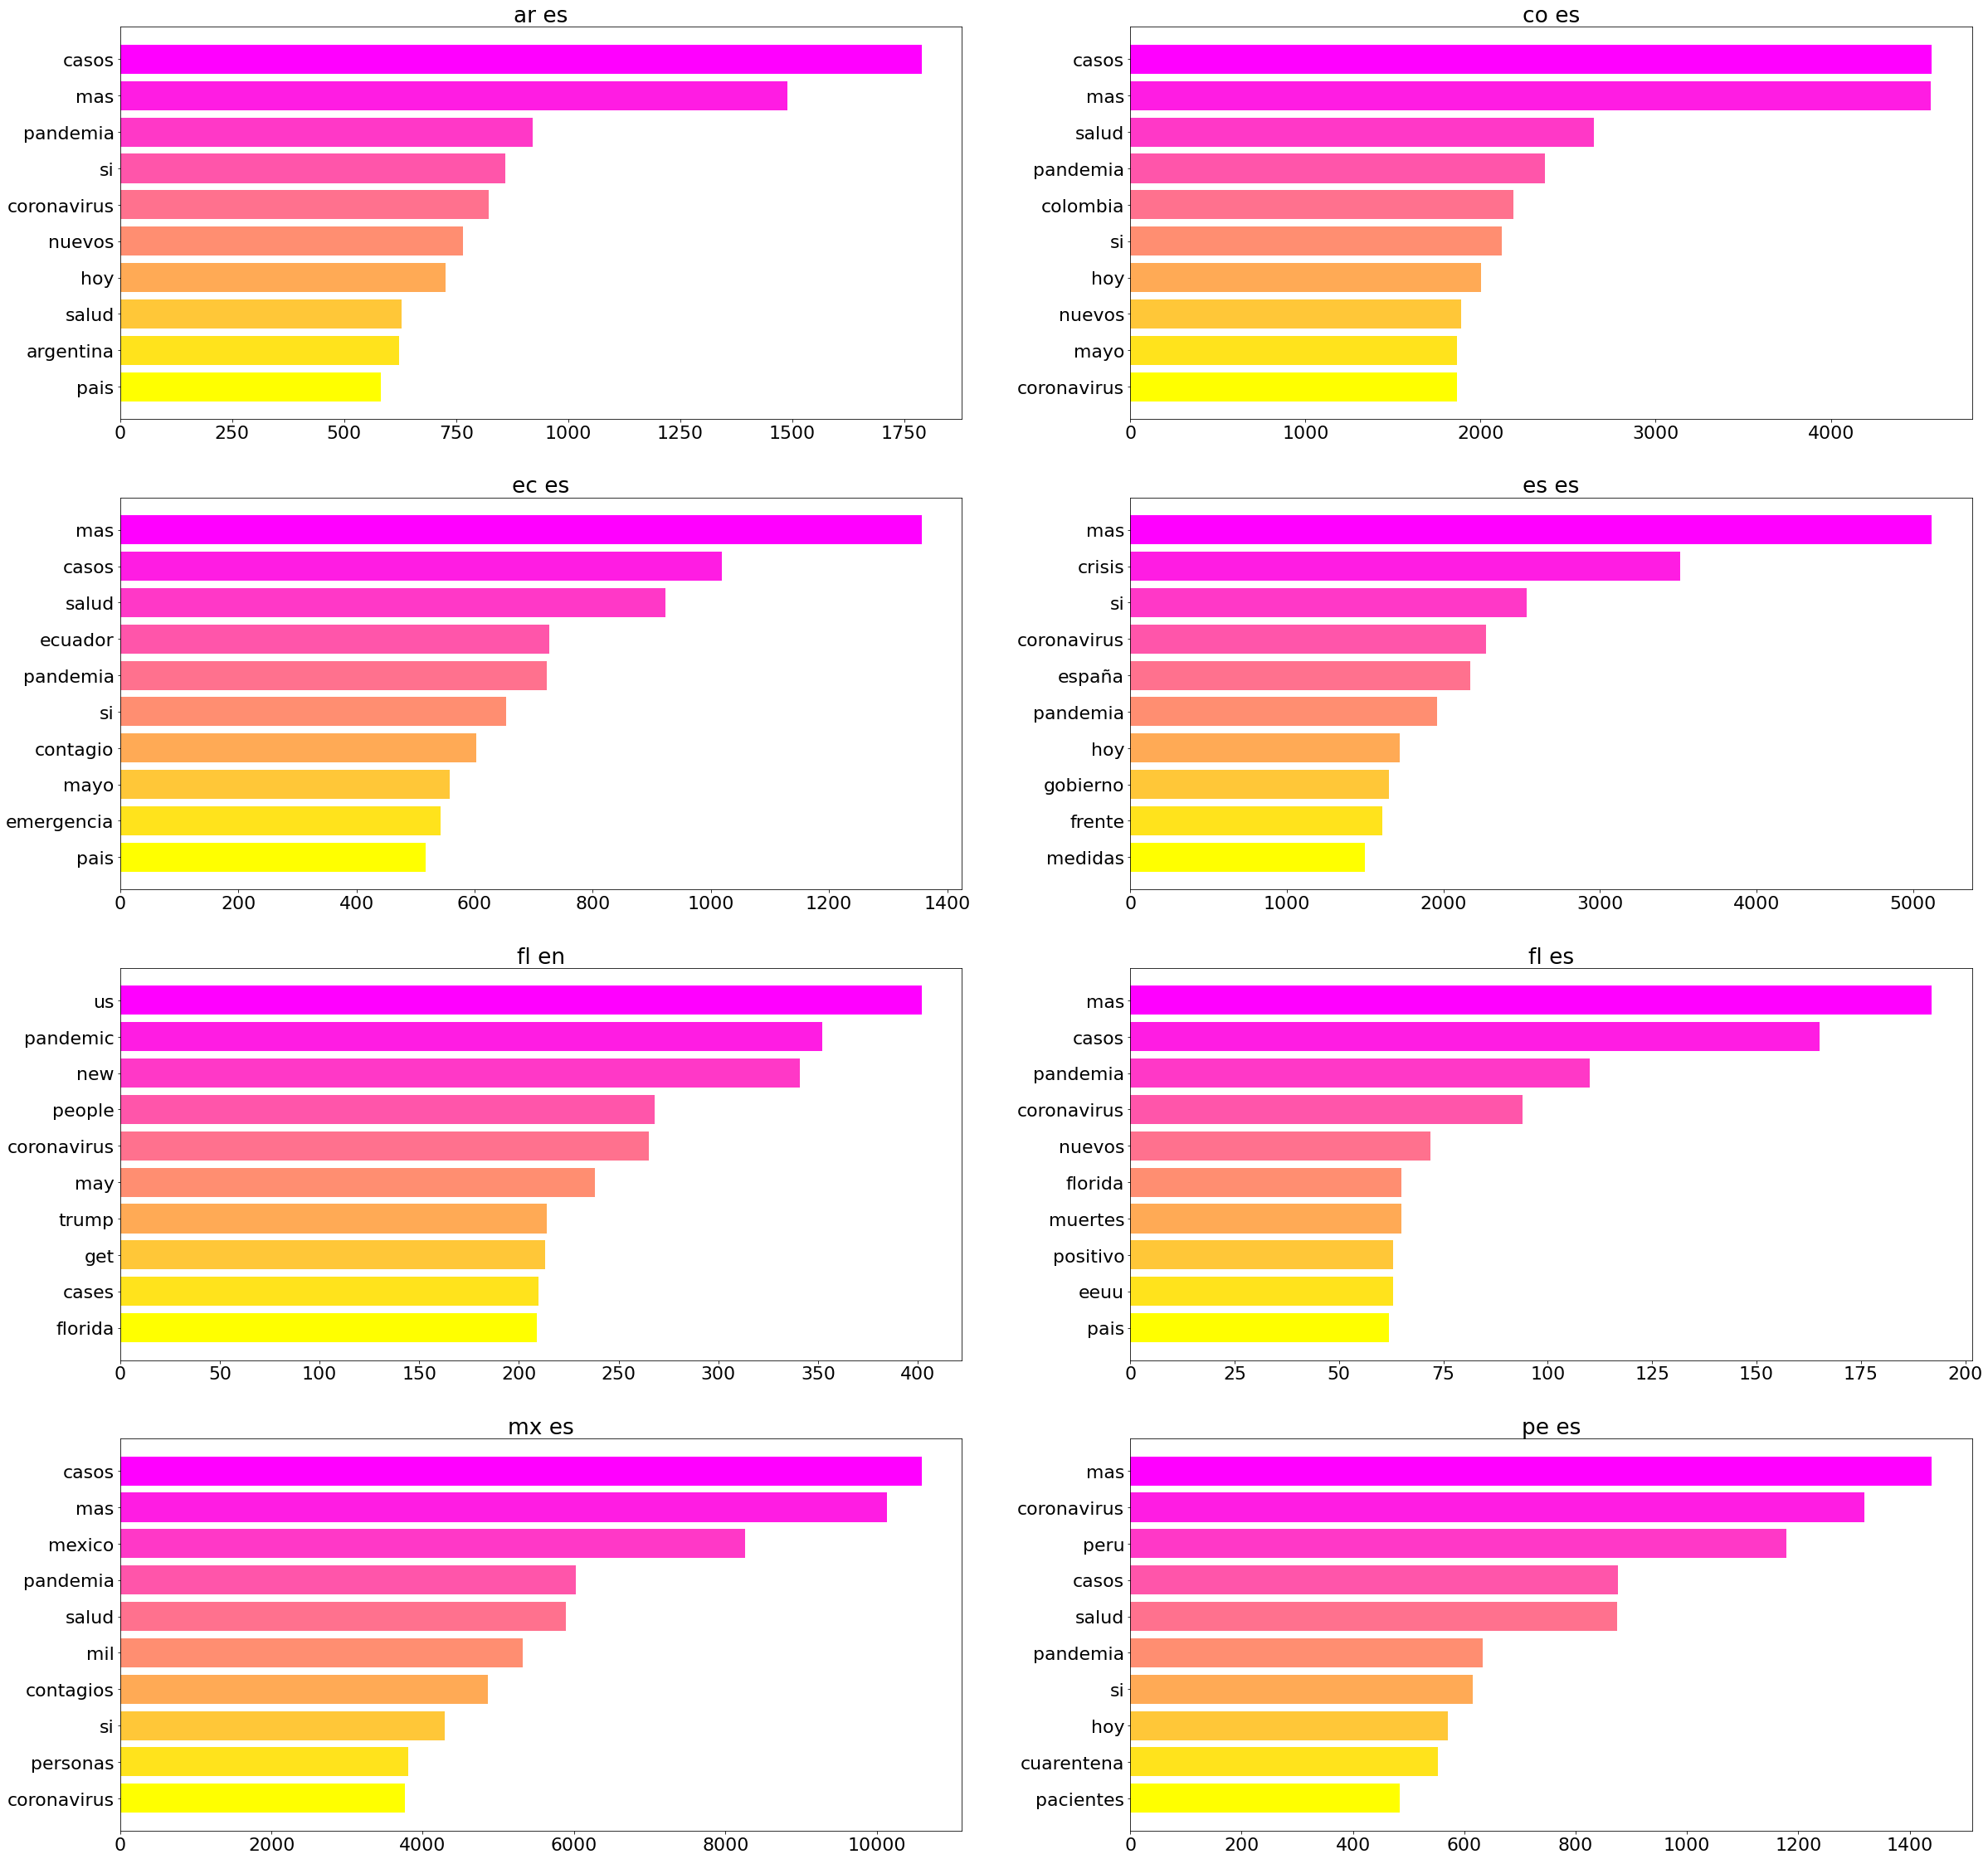

In [16]:
plot_bar_matrix(counts, num_cols = 2)

## 5. More advanced explorations 

In this final part of the notebook, I introduce two different analyses that can enable more advanced explorations of the tweet data: (1) concordance views, (2) unique words by location-language pair mode, and (3) unique words by date mode. We will still be making use of the tweet data we queried earlier in the notebook, available in `df`.  

### 5.1. Concordance views

I defer to the NLTK documentation for a definition: "a *concordance* view shows us every occurrence of a given word, together with some context." The context is usually defined by a window of some number of characters. Given the short and atomic nature of tweets, it would be fair to consider the full tweet as context for the concordance view. We would also like to display the associated date of that tweet.

The work needed to find concordances with its associated date is straightforward thanks to `pandas` and the query CSV we have available from earlier in the pipeline (part 1). The query CSV is suitable for this task because the stopwords have not been eliminated yet so we are able to study the context. The remaining work is to load it in again with `pandas` :-) 

In [17]:
df_concord = pd.read_csv('dhcovid_2020-5-8_2020-5-14_en_es_ar_co_ec_es_fl_mx_pe.csv', index_col=0)
df_concord = df_concord.dropna(subset=["text"])

With `df_concord` we can filter the rows to include only those that match the given word. This filter `filt` can be as simple as a single word (tweets where `nuevo` appears) or as advanced as logical expressions (tweets where `nuevo` and `america` appears). I show examples for both. 

In [18]:
filt = lambda text: 'nuevo' in text  # a single word
# filt = lambda text: 'nuevo' in text and 'america' in text      # a logical expression 
# filt = lambda text: 'trump' in text and not 'china' in text    # another one to try

In [19]:
df_concord = df_concord[df_concord.apply(lambda x: filt(x["text"]), axis=1)]

In [20]:
df_concord

,date,lang,geo,text,hashtags
41,2020-05-08,es,es,brasil confirmo 751 nuevos decesos por en las ultimas 24 horas el mayor numero registrado en una sola jornada desde el inicio de la pandemia y el total de fallecidos llego a 9897,#coronavirus
49,2020-05-08,es,es,el salon del vehiculo de ocasion y seminuevo de madrid 2020 ya tiene fecha la celebracion del salon del vehiculo de ocasion y seminuevo de madrid 2020 tuvo que s ser aplazada a causa de la pandemia generada por el coronavirus covid19 ahora ifema ha,NaN
112,2020-05-08,es,es,se aceleran los contagios en por ascienden a 240 casos nuevos,#argentina #covid19 #coronavirusargentina
171,2020-05-08,es,es,confiemos pfizer anuncia nuevos avances en la lucha contra el covid19,NaN
207,2020-05-08,es,es,nuevo guia de para la elaboracion del plan de contingencia por el covid19,#guiaprl #prl #sst #covid19
...,...,...,...,...,...
219489,2020-05-14,es,pe,bolivia 184 nuevos casos y 14 muertos por covid19 en un dia,#esultimo #deahora
219492,2020-05-14,es,pe,184 nuevos casos de covid19 en el pais sobrepasando los 3000 casos en todo el pais,#ultimo
219546,2020-05-14,es,pe,el ejercicio podria impedir la cascada inflamatoria que agrava el covid19 el nuevo,NaN
219575,2020-05-14,es,pe,chile registro este miercoles un total de 2660 nuevos casos del covid19 lo que supone un aumento del 60 en las ultimas 24,NaN


It would be useful to write this dataframe to file so let's do that. 

In [21]:
df_concord.to_csv("concordance_view.csv")

### 5.2. Unique words by location-language pair mode

We may be interested in obtaining words that are *unique* to a location-language pair, i.e., for an input file that contains information about `mx-es`, `es-es`, and `fl-es`, words that occur *only* in `mx-es` and not in `es-es` and `fl-es`. 

We can invoke the function `uniq_vocab_by_group()` from *coveet* to retrieve a dictionary for a location-language pair's unique vocabulary, and filter `df` with that dictionary using `apply()` from `pandas`. Put less technically, each row of `df` will only contain words/hashtags that are unique to that location-language pair.

In [24]:
grouping = df.groupby(["geo", "lang"])["text"]
vocab_dic = uniq_vocab_by_group(grouping)  # unique vocab dictionary 
# recall that col_name is a toggle variable set earlier in the notebook ("text" or "hashtags")
df[col_name] = df.apply(lambda x : set(x[col_name]) & vocab_dic[(x['geo'], x['lang'])],
                        result_type='reduce', axis=1)  # filtering tweets by that dic

Let's visualize top frequencies!

In [25]:
counts = {k: Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n) for k, t in grouping}

In [26]:
pprint(counts)

{('ar', 'es'): [(('astori',), 67),
                (('bonaerense',), 36),
                (('amba',), 35),
                (('macri',), 35),
                (('conurbano',), 32),
                (('asse',), 25),
                (('porteñas',), 24),
                (('0420',), 22),
                (('quilmes',), 22),
                (('sinae',), 20)],
 ('co', 'es'): [(('boyaca',), 147),
                (('monteria',), 95),
                (('corabastos',), 64),
                (('tunja',), 62),
                (('cucuta',), 60),
                (('bucaramanga',), 58),
                (('panameños',), 45),
                (('veraguas',), 41),
                (('manizales',), 41),
                (('panameña',), 41)],
 ('ec', 'es'): [(('ñuka',), 8),
                (('09d01',), 8),
                (('may2021',), 8),
                (('inalterable',), 8),
                (('577',), 8),
                (('ambato',), 8),
                (('recuerdelo',), 8),
                (('weir',), 7),
 

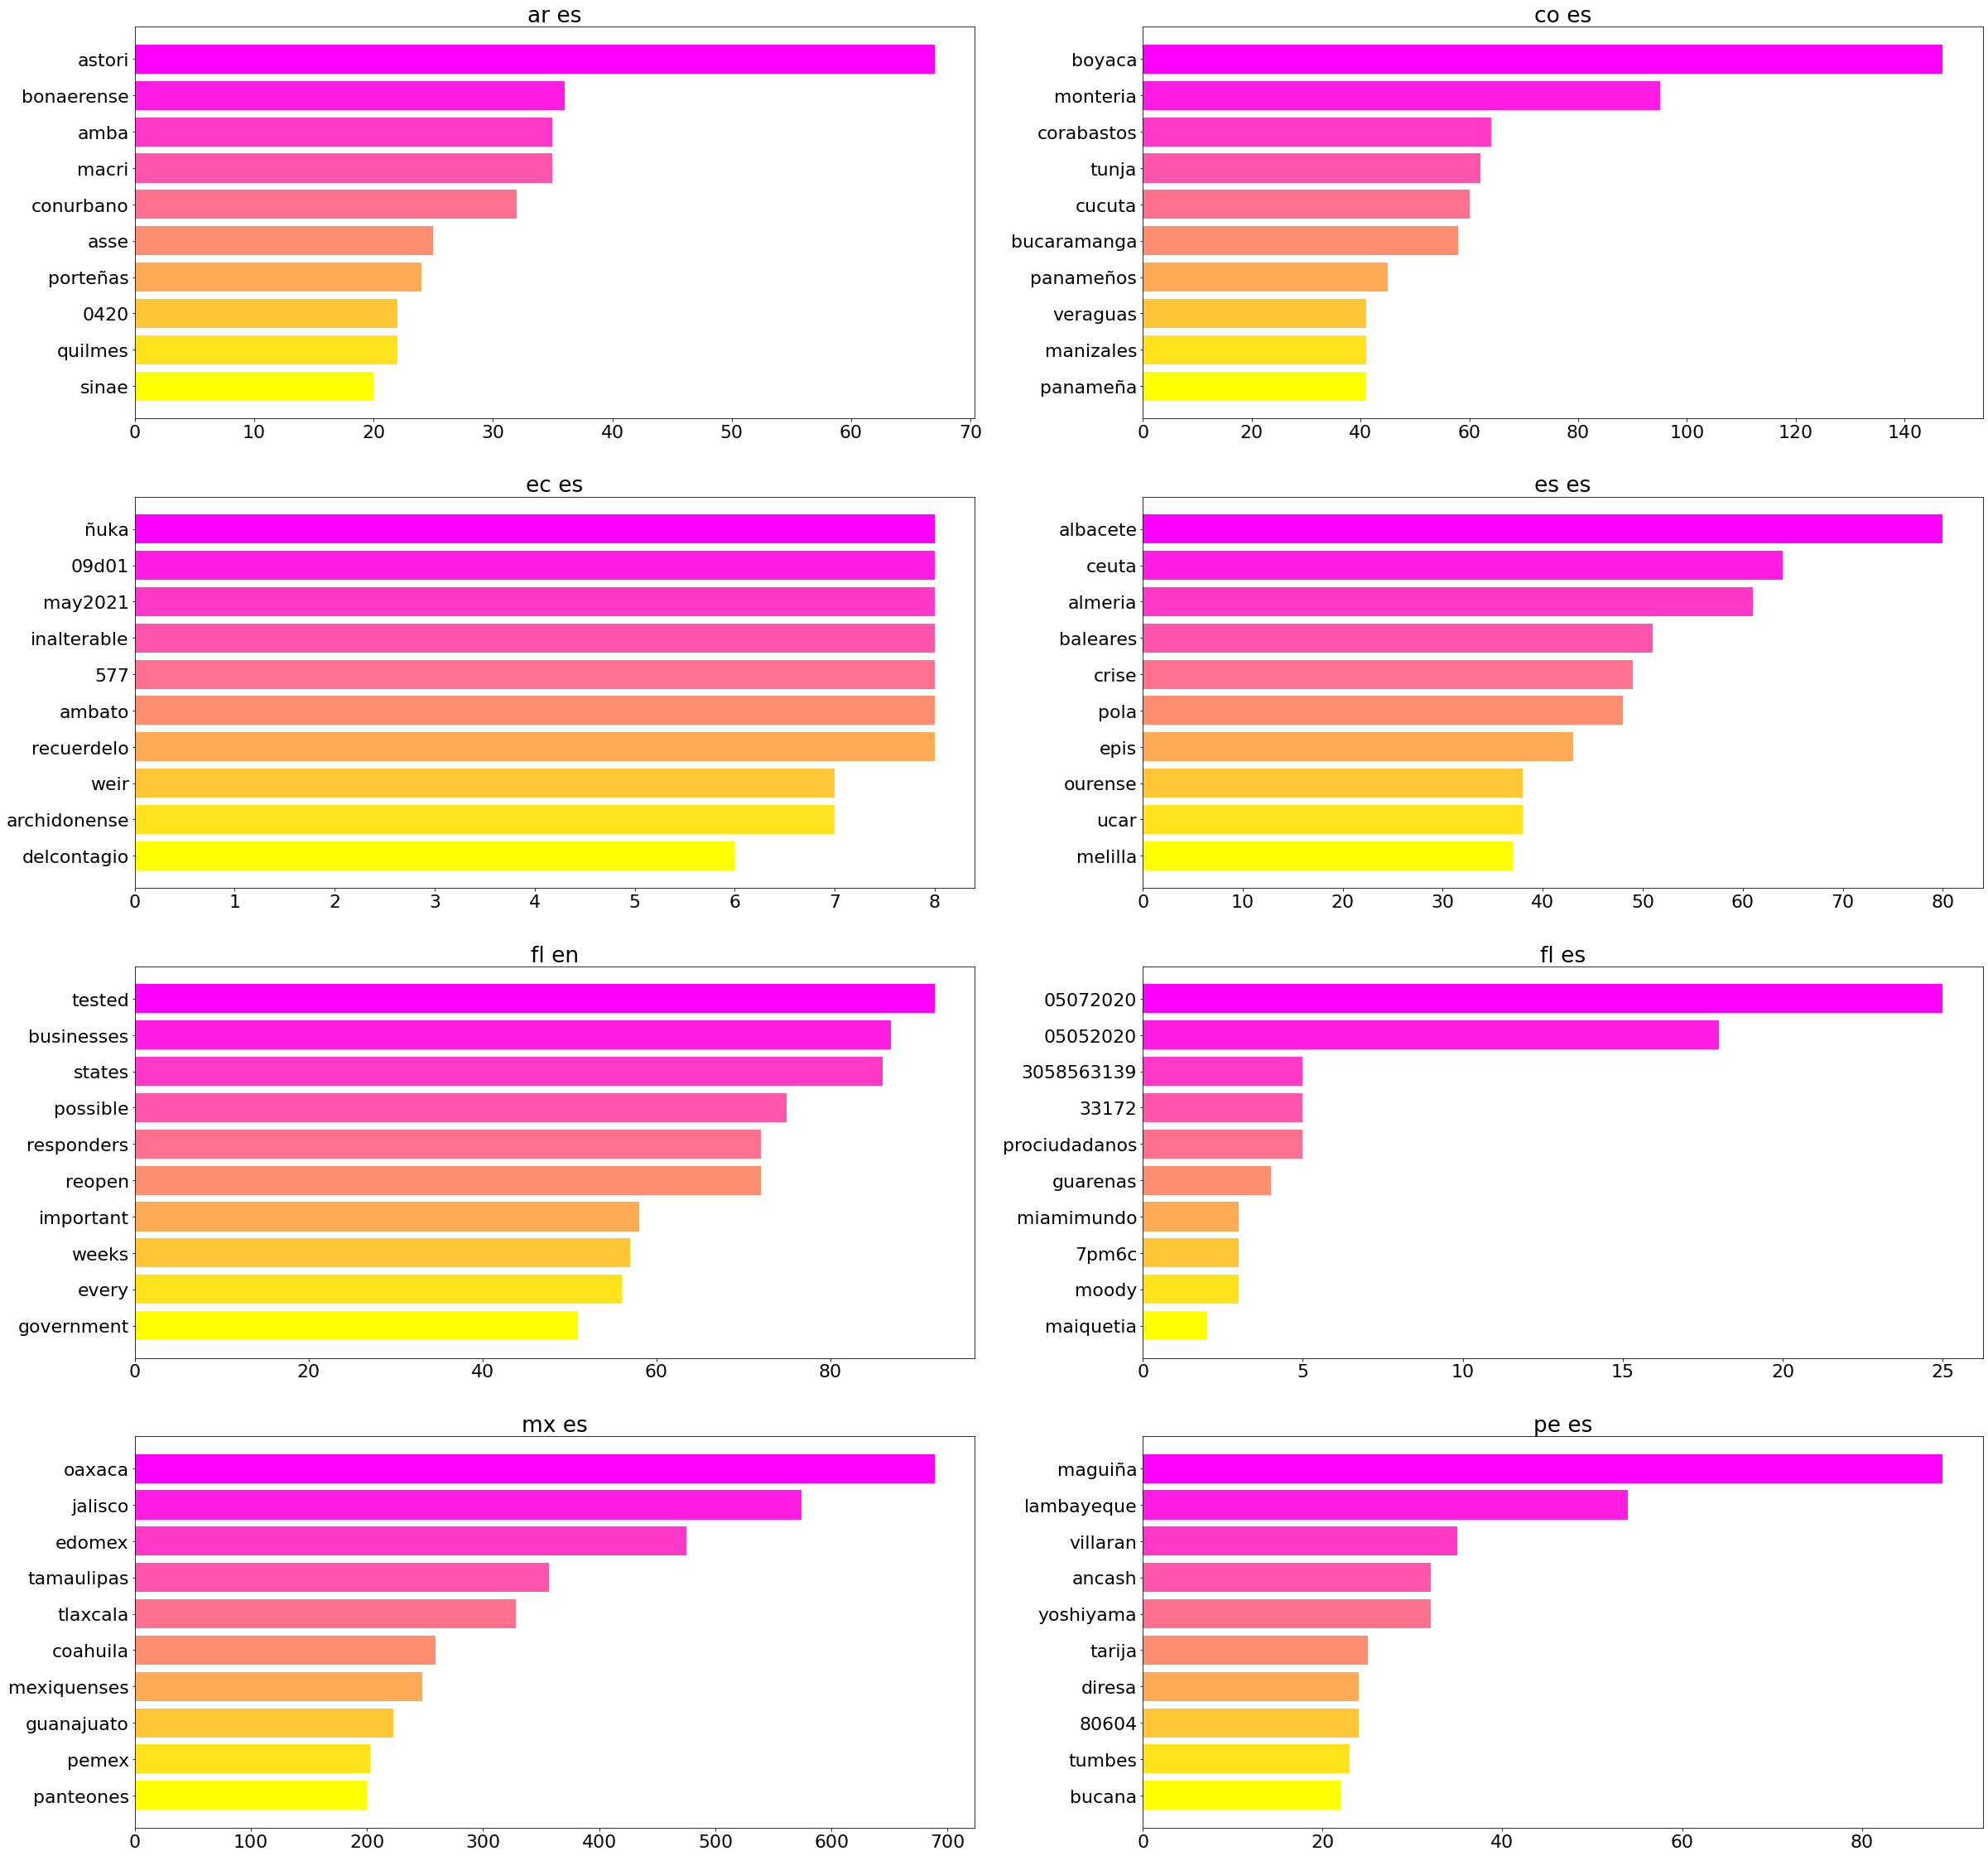

In [27]:
plot_bar_matrix(counts, num_cols = 2)

Note the words that are most frequent using this method and how it is (or isn't?) in conversation with the pandemic. Some surprising results can be observed: in `fl es`, the phone number `3058563139` is unique to Florida-Spanish and occurs frequently enough to make the top list. A quick search reveals this is the contact information for an immigration attorney. 

### 5.3 Unique words by date mode

Instead of obtaining words that are unique with respect to a location-language pair, we may be interested in retrieving words that are unique with respect to a given __date__. For instance, during the week of May 8, we may be interested in the words that occurred *only* on May 8, on May 9, and so on. This can help us understand trends. 

The work needed to accomplish this is analogous to Section 4.2. However, unlike the unique word mode for location-language pairs, this mode is best suited for studies on individual countries, e.g., the unique words by date in `fl-es`. Let's try this mode for `fl-es` during the week of May 8.

First, we need to prepare a query CSV with the contents of `fl-es` only. Remember that `coveet` is general and will work with whatever data is present in the CSV.  

In [28]:
!python3 coveet.py query -g fl -l es -d 2020-05-08 2020-05-14

Namespace(date=[datetime.datetime(2020, 5, 8, 0, 0), datetime.datetime(2020, 5, 14, 0, 0)], func=<function handle_query at 0x124331f80>, geo=['fl'], lang=['es'])
wrote df to dhcovid_2020-5-8_2020-5-14_es_fl.csv 🎉


As before, we need to tidy up the query CSV. Because this is a smaller file, we can also demonstrate lemmatization here. 

In [29]:
!python3 coveet.py tidy -file dhcovid_2020-5-8_2020-5-14_es_fl.csv -lemmatize -stopwords ../stopwords/stopwords_en.txt ../stopwords/stopwords_es.txt ../stopwords/stopwords_hashtags.txt

Namespace(file='dhcovid_2020-5-8_2020-5-14_es_fl.csv', func=<function handle_tidy at 0x1240eb0e0>, lemmatize=True, stopwords=['../stopwords/stopwords_en.txt', '../stopwords/stopwords_es.txt', '../stopwords/stopwords_hashtags.txt'])
2020-07-29 03:00:31 INFO: Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| pretrain  | ewt     |

2020-07-29 03:00:31 INFO: File exists: /Users/jerrybonnell/stanza_resources/en/tokenize/ewt.pt.
2020-07-29 03:00:31 INFO: File exists: /Users/jerrybonnell/stanza_resources/en/pos/ewt.pt.
2020-07-29 03:00:31 INFO: File exists: /Users/jerrybonnell/stanza_resources/en/lemma/ewt.pt.
2020-07-29 03:00:31 INFO: File exists: /Users/jerrybonnell/stanza_resources/en/pretrain/ewt.pt.
2020-07-29 03:00:31 INFO: Finished downloading models and saved to /Users/jerrybonnell/stanza_resources.
2020-07-29 03:00:31 INFO: Downloading these cust

We read in the tidy CSV into a pandas data frame and do the usual pandas preprocessing work.

In [30]:
df = pd.read_csv('dhcovid_2020-5-8_2020-5-14_es_fl_stopworded_lemmatized.csv')
df['date'] = pd.to_datetime(df['date'])
df['text'] = df['text'].str.split()
df['hashtags'] = df['hashtags'].str.split()

We prepare the unique vocabulary dictionary as we did earlier, and then obtain `counts`.

In [31]:
grouping = df.groupby([pd.Grouper(key='date', freq='D'), "geo", "lang"])["text"]  # D or W-MON
vocab_dic = uniq_vocab_by_group(grouping)  # unique vocab dictionary 
# recall that col_name is a toggle variable set earlier in the notebook ("text" or "hashtags")
df[col_name] = df.apply(lambda x : set(x[col_name]) & vocab_dic[(x['date'], x["geo"], x["lang"])],
                        result_type='reduce', axis=1)  # filtering tweets by that dic
# note to jerry: remember to un-tuple if the id pairs are date only

In [32]:
counts = {k: Counter(count_ngrams(t, n_gram, consecutive=False)).most_common(top_n) for k, t in grouping }

We print `counts` for inspection. Note how the key in this dictionary is not a `geo-lang` pair, but rather a `date-geo-lang` pair. 

In [33]:
pprint(counts)

{(Timestamp('2020-05-08 00:00:00', freq='D'), 'fl', 'es'): [(('comprobar',), 4),
                                                            (('madonna',), 4),
                                                            (('homenaje',), 3),
                                                            (('29',), 3),
                                                            (('cadaver',), 3),
                                                            (('381',), 3),
                                                            (('orlar',), 3),
                                                            (('odio',), 3),
                                                            (('2400',), 3),
                                                            (('petare',), 3)],
 (Timestamp('2020-05-09 00:00:00', freq='D'), 'fl', 'es'): [(('playa',), 3),
                                                            (('consolidar',),
                                                             3),
    

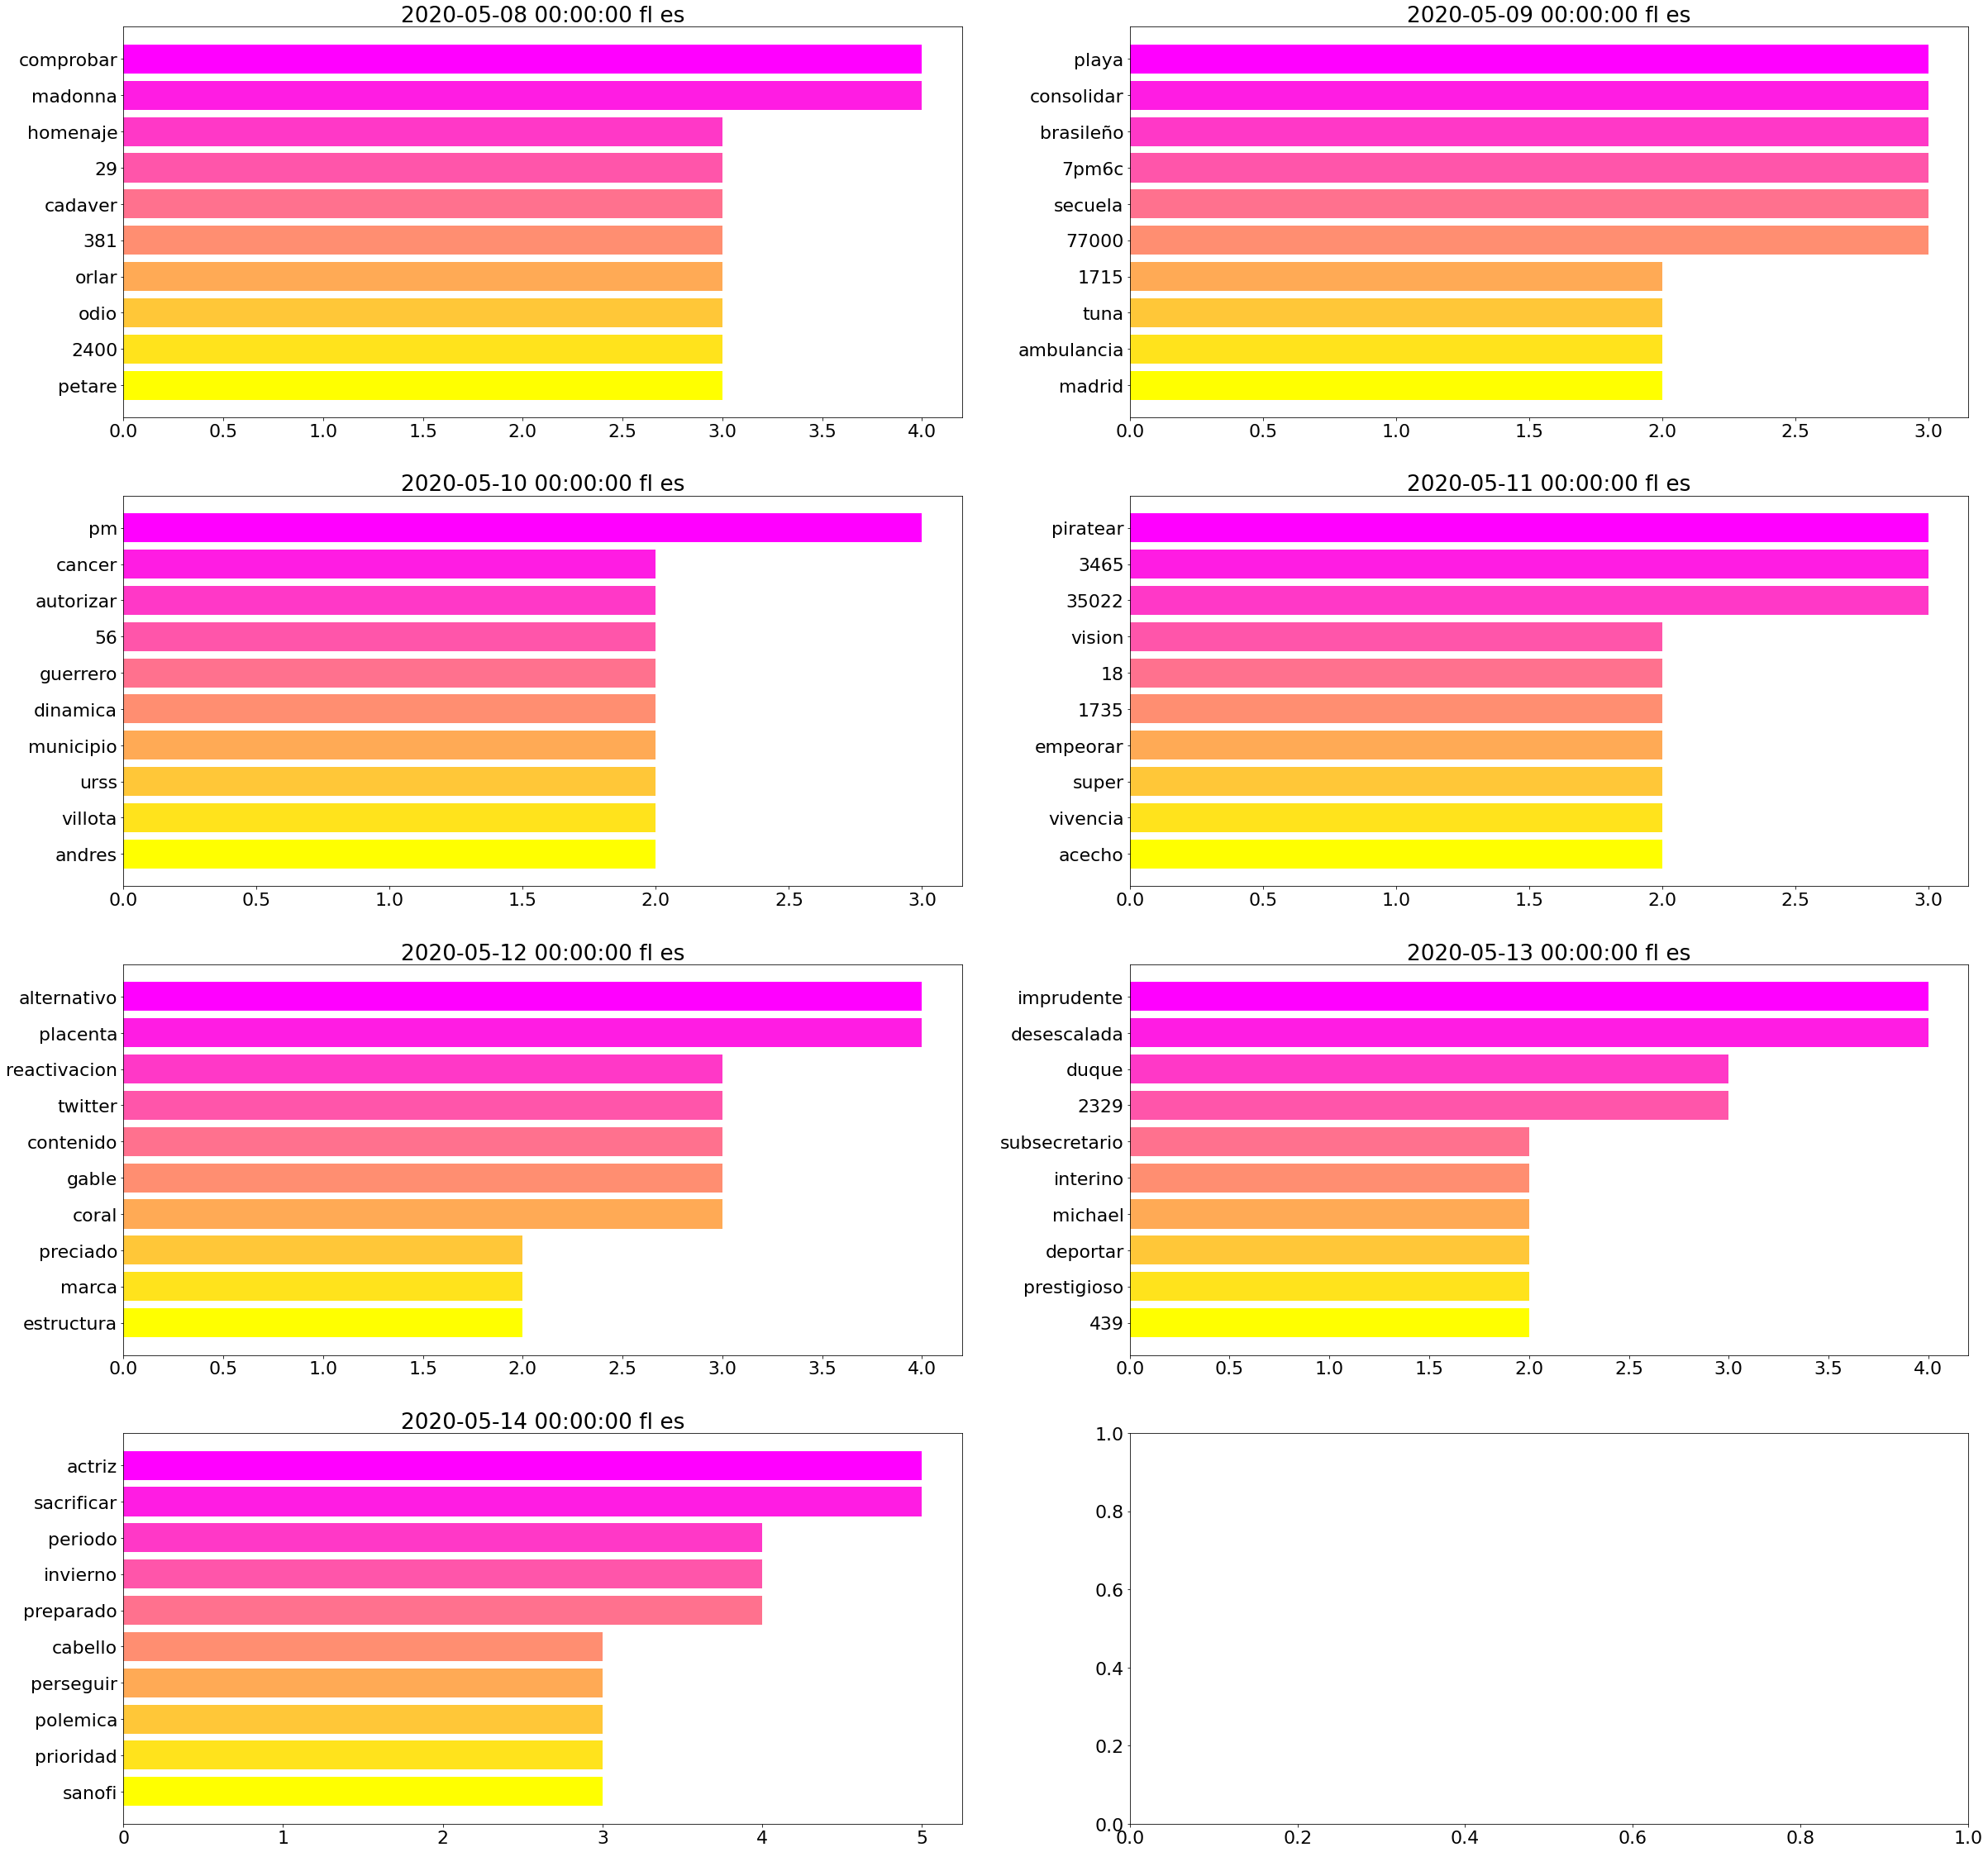

In [34]:
plot_bar_matrix(counts, num_cols = 2)

Note the very low frequency of words in this bar plot matrix, when compared to the unique words by location-language mode. That points to the idea that the vocabulary space of a location-language pair tends to be consistent from day to day. Some things to consider for experimentation:

* What happens when trying this mode in different weeks, e.g., the period immediately preceeding/following the spike of cases in Florida? Does the vocabulary space still remain consistent? 
* How about for location-language pairs other than `fl-es`?  
* Rather than day-by-day analysis, considering week-by-week or month-by-month analysis, i.e., the week becomes the unit of measure rather than the day.